# Case Study 1
---
<div style="margin: -10px 0 20px 0"><small>Author: Daniel Kończyk (18208152)</small></div>

This case study focuses on network analysis and modeling by using graphs taken from the `SNAP` repository.

The study uses the following software:
* Python v3.7
* matplotlib package v3.1
* numpy package v1.16
* networkx package v2.3
* pandas package v0.24

The notebook has been executed on the following environment:
* Linux and macOS (PC and laptop)
* 16GB RAM
* 4-core CPU

I've selected fairly large graphs for analysis to make this case study a bit more challenging, but unfortunately this also results in **fairly high computation time** in some parts of the study and at some point I had to add extra swap to cope with the load. These computations are generally CPU-intensive and memory usage should be fairly low (less than 8GB). They have been wrapped in timing code to clearly show the expected runtime and actual values have been put in comments to skip the compuation altogether, if needed. 

We start the notebook with importing all required packages and modules.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import networkx as nx
import time
import datetime
import itertools
import random
import pandas as pd
from IPython.display import display_html 
from collections import defaultdict
from functools import reduce

The graphs were downloaded from the `SNAP` repository and stored locally for convenience.  
* For directed graph **Stanford web graph** was chosen and downloaded from https://snap.stanford.edu/data/web-Stanford.html
* For undirected graph **Autonomous systems by Skitter** was chosen and downloaded from https://snap.stanford.edu/data/as-Skitter.html

The references to the downloaded and unpacked files are then stored in the following variables for later use:

In [2]:
directed_graph_file = "web-Stanford.txt"
undirected_graph_file = "email-Enron.txt"

##  “Broder et al” butterfly picture of the directed network

We start with computing Strongly Connected Components (SCC) in the directed graph of choice. While there are ready-made functions in networkx, I've decided to implement one of the known algorithms (*Kosaraju's algorithm*) and use my own simple data structure to represent the graph.

For the purpose of SCC computation, the graph is represented as an adjacency list, where each key represents a node and value represents its neighbours as a set of nodes.

In [3]:
G = defaultdict(list)
# Load data into the graph data structure
with open(directed_graph_file, "r") as ins:
    for line in ins:
        if not line.startswith("#"):
            u, v = [int(i) for i in line.split()]
            G[u].append(v)

As mentioned before, I chose to implement *Kosaraju's algorithm* to compute SCC in the directed graph. The complexity of this algorithm is $O(E+V)$. The main idea here is that the SCCs in graph G are the same as in the transpose of G (direction of every edge reversed).  
The implementation is much cleaner with recursive DFS, but this often fails in large graphs due to stack overflows, so I decided to implement an iterative DFS version from the start:

In [4]:
# Compute SCC
def scc(G):
    """
    Run Depth First Search to find out the finish times 
    to find each vertex in graph G.
    Pass the visited set in case we have a disconnected graph
    """
    visited, finish_times = set(), []
    for u in list(G.keys()):
        if u not in visited:
            finish_times.extend([v for v in dfs(G, u, visited)])
    
    # Reverse graph G
    GR = defaultdict(list)
    for u, nodes in G.items():
        for v in nodes:
            GR[v].append(u)
    
    """
    Compute strongly connected components by running Depth First Search
    on a reversed graph G, by exploring in reversed finish_times order.
    Pass the visited set to no explore the same components multiple times
    """
    visited, scc = set(), defaultdict(set)
    for u in reversed(finish_times):
        if u not in visited:
            scc[u].update([node for node in dfs(GR, u, visited)])
    return scc

# Run iterative DFS to prevent stack overflow in large graphs
def dfs(G, source, visited):
    stack, popped = [source], set()
    while stack:
        node = stack[-1]
        to_visit = set(G[node]) - visited
        if node not in visited:
            visited.add(node)
            stack.extend(to_visit)
        else:
            stack.pop()
            if node not in popped:
                popped.add(node)
                yield node

Finally, we are ready to compute the SCC and extract the giant (largest SCC) component. Additionaly we extract the nodes that are not in the giant SCC to make further computations easier:

In [5]:
s = time.perf_counter()
components = [set(c) for c in sorted(scc(G).values(), key=len)]
# largest SCC
giant = components[-1]
# nodes not in largest SCC
not_giant = reduce(set.union, components[:-1])
print("Computation time: {}".format(datetime.timedelta(seconds=int(time.perf_counter()-s))))

Computation time: 0:00:17


Having the components computed, we are ready to find the IN and OUT sections of the graph.  
* The size of an IN section can be found by iterating over the nodes outside the giant SCC and checking for intersection of their neighbours with the giant SCC
* The size of an OUT section can be found by iterating over the nodes in the giant SCC and checking for intersection of their neighbours with nodes outside the giant SCC

In [6]:
in_nodes = 0
for u in not_giant:
    if set(G[u]).intersection(giant):
        in_nodes += 1

In [7]:
out_nodes = 0
for u in giant:
    if set(G[u]).intersection(not_giant):
        out_nodes += 1

We can now print out the results for this section:

In [8]:
print("Nodes in the giant SCC: {}".format(len(giant)))
print("Nodes in the IN section of the graph: {}".format(in_nodes))
print("Nodes in the OUT section of the grap: {}".format(out_nodes))

Nodes in the giant SCC: 150532
Nodes in the IN section of the graph: 26239
Nodes in the OUT section of the grap: 2604


## The parameter β of the power-law degree distribution model

The next part of the study focuses on fitting a line to a log-log plot of the degree distribution of both graphs and computing its slope to determine the parameter $\beta$ of the power-law degree distribution model.

We start by loading both graphs from files, this time using `networkx` package:

In [9]:
s = time.perf_counter()
D = nx.read_edgelist(directed_graph_file, create_using=nx.DiGraph(), nodetype=int)
G = nx.read_edgelist(undirected_graph_file, create_using=nx.Graph(), nodetype=int)
print("Loading time: {}".format(datetime.timedelta(seconds=int(time.perf_counter()-s))))

Loading time: 0:00:10


The parameter $\beta$ can be easily determined from the CCDF, where $P(D_v>d)=\big(\frac{d}{d_{min}}\big)^{-\beta}$ and $\beta = \alpha-1$.  
A few functions to compute the necessary data are created:
* `gen_ccdf` computes CCDF from the degree view of a graph, returning a tuple with lists of $x$ and $y$ values, where $x$ are degrees of the graph and $y$ are the associated probabilities of the CCDF. This function adds 1 to each degree if the smallest degree is 0 to avoid problems with log function
* `plot_ccdf` plots the CCDF (x,y values) along with the fitted line (fit_coeffs)
* `fit_cdf` fits a line to a log-log of the CCDF by using *polyfit* function from numpy

In [10]:
def gen_ccdf(degrees):
    hist = {}
    c = 0
    if min([d for _, d in degrees]) == 0:
        c = 1    
    for d in [d+c for _, d in degrees]:
        hist[d] = hist.get(d,0) + 1

    cumsum = 0
    ccdf = {}
    for d in sorted(hist.keys(), reverse=True):
        cumsum += hist[d]
        ccdf[d] = cumsum/len(degrees)
    x,y = zip(*(ccdf.items()))
    return np.array(x), np.array(y)
        
def plot_ccdf(x, y, fit_coeffs, title, line="-"):
    plt.loglog(x,y,line)
    if fit_coeffs is not None:
        x1 = sorted(x)
        poly = np.poly1d(fit_coeffs)
        yfit = lambda x: np.exp(poly(np.log(x)))
        plt.loglog(x1,yfit(x1),"--",color="r")
    plt.ylim(1e-6)
    plt.xlabel("in-degree ($d$)")
    plt.ylabel("$P(D_v > d)$")
    plt.title(title)

def fit_ccdf(x, y):
    return np.polyfit(np.log(x), np.log(y), 1)

We are now ready to plot the CCDF of the directed graph and compute the slop and paramter $\beta$:

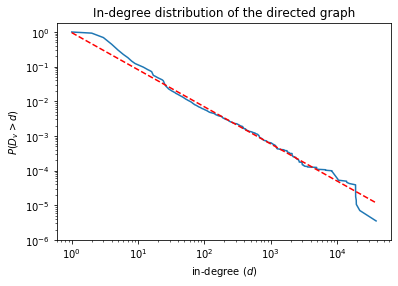

Parameter β: 1.0704116161096786
Parameter α: 2.070411616109679


In [11]:
x, y = gen_ccdf(D.in_degree())
coeffs = fit_ccdf(x,y)
plot_ccdf(x, y, coeffs, "In-degree distribution of the directed graph")
plt.show()
D_beta = -coeffs[0]
D_alpha = D_beta+1
print("Parameter β: {}".format(D_beta))
print("Parameter α: {}".format(D_alpha))

And the same plot of the CCDF and the fit line but for the undirected graph:

[-1.42494389  2.10733612]


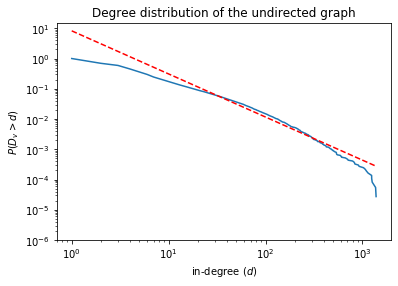

Parameter β: 1.4249438869885158
Parameter α: 2.424943886988516


In [12]:
x, y = gen_ccdf(G.degree())
coeffs = fit_ccdf(x,y)
print(coeffs)
plot_ccdf(x, y, coeffs, "Degree distribution of the undirected graph")
plt.show()
G_beta = -coeffs[0]
G_alpha = G_beta+1
print("Parameter β: {}".format(G_beta))
print("Parameter α: {}".format(G_alpha))

## Graph metrics

For most of the metrix `networkx` is used, but due to quite large graphs being selected, computing average path lengths was impossible on the full set of nodes (test run was executing for a few hours before I stopped it). Thus an auxillary function was provided to compute this metric only on a $N$ sample of nodes. The seed is used to get consistent results over multiple runs:

In [13]:
def avg_shortest_path(G, N):
    visited = set()
    nodes = list(G.nodes())
    np.random.seed(12345)
    np.random.shuffle(nodes)
    avg = []
    for n in range(N):
        node = nodes[n]
        visited.add(node)
        lengths = []
        for s, l in nx.single_source_shortest_path_length(G,node).items():
            if s != node and G.is_directed() is True or s not in visited:
                lengths.append(l)
        if len(lengths) > 0:
            avg.append(np.mean(lengths))
    return np.mean(avg)

I added pre-computed values for some of the variables in order to save time on the re-runs, since the computation takes a significant amount of time. Part of it might be inefficient implementation as computing a clustering coefficient on the same graph takes a few seconds in R (igraph) vs almost 15 minutes in Python's networkx.  
We can just comment out actual code invocations if needed:

In [14]:
s = time.perf_counter()
D_assortativity = nx.degree_pearson_correlation_coefficient(D)
# pre-computed value
D_clustering = 0.5976304608024073
#D_clustering = nx.average_clustering(D.to_undirected())
# pre-computed value
D_shortest_path = 16.109514211378873
#D_shortest_path = avg_shortest_path(D, 2000)
print("Computation time: {}".format(datetime.timedelta(seconds=int(time.perf_counter()-s))))

Computation time: 0:00:10


And now we can report the metrics for the **directed** graph:

In [15]:
print("Degree Assortativity Coefficient:\t{}".format(D_assortativity))
print("Average Clustering Coefficient:\t\t{}".format(D_clustering))
print("Average path length (sampled):\t\t{}".format(D_shortest_path))

Degree Assortativity Coefficient:	-0.12201270653192606
Average Clustering Coefficient:		0.5976304608024073
Average path length (sampled):		16.109514211378873


---
Again, I added pre-computed values for some of the variables in order to save time on the re-runs and can just comment the actual code invocations if needed:

In [16]:
s = time.perf_counter()
G_assortativity = nx.degree_pearson_correlation_coefficient(G)
G_clustering = 0.49698255959950266
#G_clustering = nx.average_clustering(G)
G_shortest_path = 3.818097855602894
#G_shortest_path = avg_shortest_path(G, 10000)
print("Computation time: {}".format(datetime.timedelta(seconds=int(time.perf_counter()-s))))

Computation time: 0:00:02


And now we can report the metrics for the **undirected** graph:

In [17]:
print("Degree Assortativity Coefficient:\t{}".format(G_assortativity))
print("Average Clustering Coefficient:\t\t{}".format(G_clustering))
print("Average path length (sampled):\t\t{}".format(G_shortest_path))

Degree Assortativity Coefficient:	-0.11076403259610433
Average Clustering Coefficient:		0.49698255959950266
Average path length (sampled):		3.818097855602894


## Price model simulation

The algorithm is based on the following formula $\theta'_i = \phi\frac{q_i}{nc}+(1-\phi)\frac{1}{n}$, with $\phi = \frac{c}{c+a}$, where having a new node in the network, with probability $\phi$ we choose a vertex to attach to proportionally to its in-degree and with probability $1-\phi$ we choose a node at random.

Before we start the simulation, we set up the variables, re-using $D_alpha$ from previous section and compute $c$ as the average out-degree in the network (which would be *bibliography* in Prices' model):

In [18]:
c = int(np.round(np.mean([d for _,d in D.out_degree()])))
a = c*(D_alpha - 2)
phi = c *1.0/(c+a)
N = len(D)

I changed the simulation code from the one we used in the lab and followed the algorithm outlined in the Newman's book, as it seemed a bit more appropriate for my case, where I need to simulate a growth of a fairly large network. The final algorithm is indeed very simple and generates the network in just a few seconds. The main idea is to keep the set of edges (for quick lookup and to avoid duplicates) and additional list of targets, where we store information about new edges in the network. This list is also used to draw a random edge from the network, which vastly simplifies the whole procedure:

In [19]:
s = time.perf_counter()
targets = []
edges = set()
np.random.seed(42)
for n in range(N):
    # form c links from the new node to existing nodes in the network
    for j in range(c):
        r = np.random.uniform()
        # choose a node in proportion to in-degree
        if (r < phi and len(edges) > 0):
            i = np.random.randint(len(targets))
            to = targets[i]
        # choose a node at random
        else:
            to = np.random.choice(n+1)
        # don't store duplicates
        if (n, to) not in edges:
            targets.append(to)
            edges.add((n, to))
print("Computation time: {}".format(datetime.timedelta(seconds=int(time.perf_counter()-s))))

Computation time: 0:00:07


After the simulation, we can finally create a directed graph, that will load the edges produced by the code above:

In [20]:
P = nx.DiGraph()
P.add_edges_from(edges)

To support large graphs, I've developed additional function to sample average clustering coefficient, as it is taking a lot of time for some of the graphs, while the sampled one is often extremely closed to the real one:

In [21]:
def avg_clustering(G, N):
    nodes = list(G.nodes())
    np.random.seed(12345)
    np.random.shuffle(nodes)
    clustering = nx.clustering(G, nodes[:N])
    
    return np.mean(list(clustering.values()))

The following cell computes different statistics for the obtained Price model and also a few extra ones for the directed graph described before:

In [22]:
P_assortativity = nx.degree_pearson_correlation_coefficient(P)
P_clustering = avg_clustering(P.to_undirected(), 1000)
P_shortest_path = avg_shortest_path(P, 2000)
D_wcc = len(sorted(nx.weakly_connected_components(D), key=lambda x: len(x), reverse=True)[0])
P_wcc = len(sorted(nx.weakly_connected_components(P), key=lambda x: len(x), reverse=True)[0])
P_scc = len(sorted(nx.strongly_connected_components(P), key=lambda x: len(x), reverse=True)[0])
D_avg_deg = np.mean([d for _, d in D.degree()])
P_avg_deg = np.mean([d for _, d in P.degree()])

We are finally ready to plot both graphs side by side and to display the metrix for easier comparison:

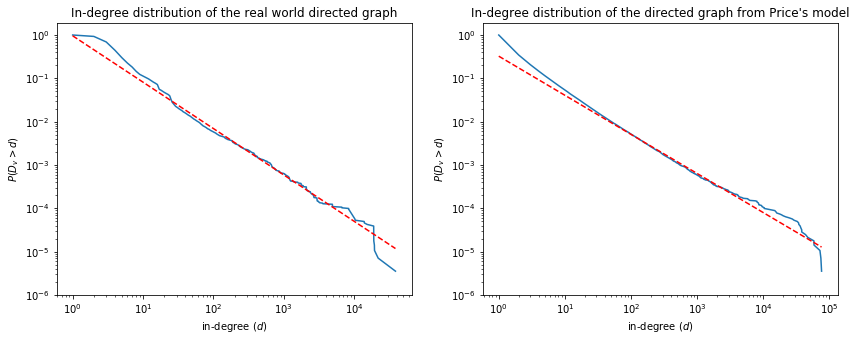

In [23]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
x, y = gen_ccdf(D.in_degree())
coeffs = fit_ccdf(x,y)
plot_ccdf(x, y, coeffs, "In-degree distribution of the real world directed graph", "-")
plt.subplot(1,2,2)
x, y = gen_ccdf(P.in_degree())
coeffs = fit_ccdf(x,y)
P_beta = -coeffs[0]
plot_ccdf(x, y, coeffs, "In-degree distribution of the directed graph from Price's model", "-")
plt.show()

The shape of the degree distribution is extremely close to the real network and the slope seems to be close enough as well. That's a really good indicator that the generated model might fit the real world pretty well, although a closer look into the numbers is required:

In [24]:
df = pd.DataFrame([
    ["Parameter β", D_beta, P_beta],
    ["Number of Nodes", D.number_of_nodes(), P.number_of_nodes()],
    ["Number of Edges", D.number_of_edges(), P.number_of_edges()],
    ["Degree Assortativity Coefficient", D_assortativity, P_assortativity],
    ["Average Clustering Coefficient", D_clustering, P_clustering],
    ["Average Shortest Path Length", D_shortest_path, P_shortest_path],
    ["Nodes in Largest Weakly Connected Component", D_wcc, P_wcc],
    ["Nodes in Largest Strongly Connected Component", len(giant), P_scc],
    ["Average degree (overall)", D_avg_deg, P_avg_deg]],
    columns=["Metric", "Real World Network", "Price's Model Network"])

df_style = (df.style
    .set_table_attributes("style='display:inline'")
    .set_caption("Networks comparison")
    .hide_index()        
    .set_precision(7))
display_html(df_style._repr_html_(), raw=True)

Metric,Real World Network,Price's Model Network
Parameter β,1.070412,0.9025683
Number of Nodes,281903,281903
Number of Edges,2312497,2176859
Degree Assortativity Coefficient,-0.1220127,-0.09886095
Average Clustering Coefficient,0.5976305,0.1777357
Average Shortest Path Length,16.10951,3.003399
Nodes in Largest Weakly Connected Component,255265,281903
Nodes in Largest Strongly Connected Component,150532,1
Average degree (overall),16.40633,15.44403


Many of the numbers look really good - the generated number of edges is very close to the real network, the slope of the distribution is fairly close as well. Obviously, some of the properties were no possible to achieve, like giant SCC, because that's the nature of Preferential Attachment network like Price's model, where nodes connect in very specific order.

The clustering coefficient is higher than I expected. I often see it on the low side in generated models, but here it's fairly high in this case. The average path length is much shorter, which was to be expected I think, in a Preferential Attachment model.

In general, this looks like a good model for the network, if we care less about some of the metrics. It could most likely well predict the growth of the network, which is remarkable for a model that took 10s to generate.

## Stochastic Kronecker simulation

The next section focuses on simulating Stochastic Kronecker product graph. I've decided to start from a 2x2 initiator matrix, which should be enough to simulate the network from my undirected graph:

In [25]:
K1 = np.array([[0.99, 0.58],[0.58,0.01]])
K2 = np.kron(K1,K1)
K3 = np.kron(K2,K2)
K4 = np.kron(K3,K3)

[[0.99 0.58]
 [0.58 0.01]]


To generate a proper number of nodes and edges, I need to calculate $K_5$ Kronecker product, but that unfortunately does not fit into 16GB of RAM I have. I've decided to write a function to build the last matrix piece by piece and immediately generate the graph edges from an active piece - this way I will never need the who matrix in memory. This turned out successful:

In [26]:
def kron(A):
    np.random.seed(42)
    part = 4
    h = int(A.shape[0]/part)
    edges = []
    for r in range(part):
        for c in range(part):
            x1,x2 = r*h, (r+1)*h
            y1,y2 = c*h, (c+1)*h
            K = np.kron(A[x1:x2, y1:y2], A)
            rnd = np.random.rand(K.shape[0], K.shape[0])
            e = map(lambda x: (r*K.shape[0]+x[0], c*K.shape[0]+x[1]), zip(*np.where(K > rnd)))
            edges += list(e)
            
    return edges

Having all the edges, we can now build the Graph using networkx:

In [27]:
K = nx.Graph()
K.add_edges_from(kron(K4))

The following cell computes different statistics for the obtained Price model and also a few extra ones for the directed graph described before:

In [31]:
K_assortativity = nx.degree_pearson_correlation_coefficient(P)
K_clustering = avg_clustering(K, 1000)
K_shortest_path = avg_shortest_path(K, 1000)
G_cc = nx.number_connected_components(G)
K_cc = nx.number_connected_components(K)
G_avg_deg = np.mean([d for _, d in G.degree()])
K_avg_deg = np.mean([d for _, d in K.degree()])

We are finally ready to plot both graphs side by side and to display the metrics for easier comparison:

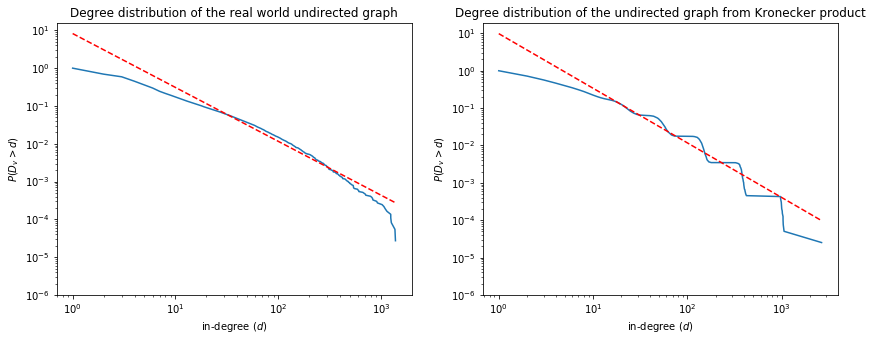

In [29]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
x, y = gen_ccdf(G.degree())
coeffs = fit_ccdf(x,y)
plot_ccdf(x, y, coeffs, "Degree distribution of the real world undirected graph", "-")
plt.subplot(1,2,2)
x, y = gen_ccdf(K.degree())
coeffs = fit_ccdf(x,y)
K_beta = -coeffs[0]
plot_ccdf(x, y, coeffs, "Degree distribution of the undirected graph from Kronecker product", "-")
plt.show()

Again, the slope of the degree distribution matches pretty well the real network, though the line is a bit wavy - I wasn't able to find paramters to smooth it out, while not losing all other properties of the current model. Finally, checking the actual numbers:

In [32]:
df = pd.DataFrame([
    ["Parameter β", G_beta, K_beta],
    ["Number of Nodes", G.number_of_nodes(), K.number_of_nodes()],
    ["Number of Edges", G.number_of_edges(), K.number_of_edges()],
    ["Degree Assortativity Coefficient", G_assortativity, K_assortativity],
    ["Average Clustering Coefficient", G_clustering, K_clustering],
    ["Average Shortest Path Length", G_shortest_path, K_shortest_path],
    ["Number of Connecteded Components", G_cc, K_cc],
    ["Average degree (overall)", D_avg_deg, P_avg_deg]],
    columns=["Metric", "Real World Network", "Kronecker Product Network"])

df_style = (df.style
    .set_table_attributes("style='display:inline'")
    .set_caption("Networks comparison")
    .hide_index()        
    .set_precision(7))
display_html(df_style._repr_html_(), raw=True)

Metric,Real World Network,Kronecker Product Network
Parameter β,1.424944,1.460604
Number of Nodes,36692,39525
Number of Edges,183831,222608
Degree Assortativity Coefficient,-0.110764,-0.09886095
Average Clustering Coefficient,0.4969826,0.02504856
Average Shortest Path Length,3.818098,3.529263
Number of Connecteded Components,1065,3
Average degree (overall),16.40633,15.44403


We can clearly see, that a lot of model metrics match extremely closely the actual network, which tells us that this could be a good model for the network in question. The only striking difference is in the clustering coefficient, but I was never able to raise this number significantly, trying many different paramters. On the other hand, even a tiny change in one of the coefficient in the initiator matrix can cause a dramatic change in the final model, so it's very likely that I missed some combinations, that could even better generate the model.

## Conclusions

This Case Study was very insightful and showed a really interesting ways to generate graphs for any real network with just a few basic tools. But even though the tools are basic, they manage to product graphs that match quite a lot real life properties. 

I'm especially surprised at how well these models can generate a right amount of edges, degree distributions and other metrics, while being controlled only by a few numbers.

On the other hand, a lot of the metrics and algorithms require a huge amount of computing power (I actually tried to compute average shortest paths for one of the graphs using R and igraph and I did not succeed even in more than 10 hours, when I gave up) and special care has to be taken when implementing some of the routines.